# Representing Data for Training RNNs in Keras
When we use recurrent networks, the most common form of data is text. In order to represent a sentence, we will need to make a few decisions. 
- Will our network fundamentally represent characters? Words? What are the building blocks for our structure?
- What is the maximum sequence length? 
- What is my maximum vocabulary size?
- What style of RNN should I use?
- Can I incorporate an Embedding? What size?
- What is my problem type? Many to one? Many to many? Sequence-to-Sequence?

A great tutorial that this notebook also uses as base code:
- http://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

Let's start with the example above and see what the representation in Keras should look like. 

In [1]:
import numpy as np
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# load the dataset but only keep the top n words, zero the rest
top_words = 1000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)

# truncate and pad input sequences to be the same length
max_review_length = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

/Users/ericlarson/opt/anaconda3/envs/mlenv2020/lib/python3.7/site-packages/tensorflow_core/python/keras/datasets/imdb.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/Users/ericlarson/opt/anaconda3/envs/mlenv2020/lib/python3.7/site-packages/tensorflow_core/python/keras/datasets/imdb.py:130: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [2]:
print(type(X_train),X_train.shape)
print(type(X_train[0]),X_train[0].shape)
print('Vocabulary size:', np.max(X_train))
print(y_train.shape, np.min(y_train), np.max(y_train))
NUM_CLASSES = 1

<class 'numpy.ndarray'> (25000, 500)
<class 'numpy.ndarray'> (500,)
Vocabulary size: 999
(25000,) 0 1


The IMDB ratings data contains: a number of different reviews and the sentiment of the review as positive or negative. 

In [3]:
# show example without the FOR loop
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, SimpleRNN
from tensorflow.keras.layers import Embedding



EMBED_SIZE = 50
RNN_STATESIZE = 100
rnns = []
input_holder = Input(shape=(X_train.shape[1], ))
shared_embed = Embedding(top_words, # input dimension (max int of OHE)
                EMBED_SIZE, # output dimension size
                input_length=max_review_length)(input_holder) # number of words in each sequence


x = SimpleRNN(RNN_STATESIZE,dropout=0.2, recurrent_dropout=0.2)(shared_embed)
x = Dense(NUM_CLASSES, activation='sigmoid')(x)
simple_rnn_model = Model(inputs=input_holder,outputs=x)


In [4]:
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# create LSTM
x = LSTM(RNN_STATESIZE, dropout=0.2, recurrent_dropout=0.2)(shared_embed)
x = Dense(NUM_CLASSES, activation='sigmoid')(x)
lstm_model = Model(inputs=input_holder,outputs=x)

# create LSTM
x = GRU(RNN_STATESIZE, dropout=0.2, recurrent_dropout=0.2)(shared_embed)
x = Dense(NUM_CLASSES, activation='sigmoid')(x)
gru_model = Model(inputs=input_holder,outputs=x)

# lr_schedule = ExponentialDecay(
#     initial_learning_rate=0.1,
#     decay_steps=10000,
#     decay_rate=0.95) 

opt = Adam(lr=0.0001, epsilon=0.0001, clipnorm=1.0)

simple_rnn_model.compile(loss='binary_crossentropy', 
              optimizer= opt, 
              metrics=['accuracy'])

lstm_model.compile(loss='binary_crossentropy', 
              optimizer= opt, 
              metrics=['accuracy'])

gru_model.compile(loss='binary_crossentropy', 
              optimizer= opt, 
              metrics=['accuracy'])

print(simple_rnn_model.summary())
print(lstm_model.summary())
print(gru_model.summary())


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 500, 50)           50000     
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 100)               15100     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 65,201
Trainable params: 65,201
Non-trainable params: 0
_________________________________________________________________
None
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500)]             0         
___________________________________

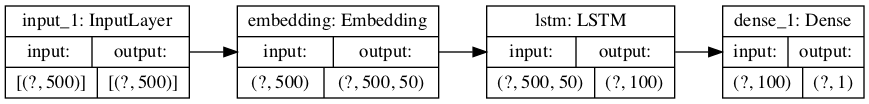

In [5]:
from tensorflow.keras.utils import plot_model

# you will need to install pydot properly on your machine to get this running
plot_model(
    lstm_model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [6]:
# takes about 2 hours to run
simple_rnn_model.fit(X_train, y_train, epochs=3, batch_size=64, validation_data=(X_test, y_test))
lstm_model.fit(X_train, y_train, epochs=3, batch_size=64, validation_data=(X_test, y_test))
gru_model.fit(X_train, y_train, epochs=3, batch_size=64, validation_data=(X_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 246s 10ms/sample - loss: 0.7162 - accuracy: 0.5032 - val_loss: 0.6961 - val_accuracy: 0.5017
Epoch 2/3
25000/25000 [==============================] - 244s 10ms/sample - loss: 0.7130 - accuracy: 0.4996 - val_loss: 0.6928 - val_accuracy: 0.5120
Epoch 3/3
25000/25000 [==============================] - 245s 10ms/sample - loss: 0.7075 - accuracy: 0.5064 - val_loss: 0.6923 - val_accuracy: 0.5165
Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 609s 24ms/sample - loss: 0.6923 - accuracy: 0.5310 - val_loss: 0.6909 - val_accuracy: 0.5660
Epoch 2/3
25000/25000 [==============================] - 611s 24ms/sample - loss: 0.6838 - accuracy: 0.5788 - val_loss: 0.6763 - val_accuracy: 0.6073
Epoch 3/3
25000/25000 [==============================] - 608s 24ms/sample - loss: 0.6577 - accuracy: 0.6342 - val_loss: 0.6259 - val_accuracy: 0.7017


In [7]:
# takes about 2 hours to run
simple_rnn_model.fit(X_train, y_train, epochs=3, batch_size=64, validation_data=(X_test, y_test))
lstm_model.fit(X_train, y_train, epochs=3, batch_size=64, validation_data=(X_test, y_test))
gru_model.fit(X_train, y_train, epochs=3, batch_size=64, validation_data=(X_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 244s 10ms/sample - loss: 0.7020 - accuracy: 0.5172 - val_loss: 0.6843 - val_accuracy: 0.5565
Epoch 2/3
25000/25000 [==============================] - 244s 10ms/sample - loss: 0.6996 - accuracy: 0.5235 - val_loss: 0.6821 - val_accuracy: 0.5795
Epoch 3/3
25000/25000 [==============================] - 250s 10ms/sample - loss: 0.6948 - accuracy: 0.5278 - val_loss: 0.6841 - val_accuracy: 0.5426
Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 605s 24ms/sample - loss: 0.5038 - accuracy: 0.7801 - val_loss: 0.4623 - val_accuracy: 0.7990
Epoch 2/3
25000/25000 [==============================] - 605s 24ms/sample - loss: 0.4548 - accuracy: 0.8014 - val_loss: 0.4145 - val_accuracy: 0.8173
Epoch 3/3
25000/25000 [==============================] - 603s 24ms/sample - loss: 0.4299 - accuracy: 0.8128 - val_loss: 0.3902 - val_accuracy: 0.8276


In [10]:
# this operation can take time 
yhat_rnn = simple_rnn_model.predict(X_test)
yhat_lstm = lstm_model.predict(X_test)
yhat_gru = gru_model.predict(X_test)

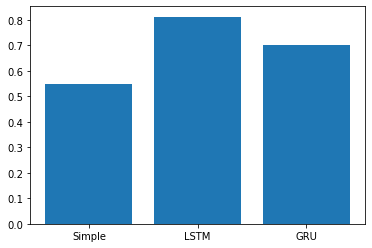

In [14]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
%matplotlib inline

acc = [mt.accuracy_score(y_test,np.round(yhat_rnn)),
       mt.accuracy_score(y_test,np.round(yhat_lstm)),
       mt.accuracy_score(y_test,np.round(yhat_gru)),
      ]

plt.bar([1,2,3],acc)
plt.xticks([1,2,3],['Simple','LSTM','GRU'])
plt.show()

_____

# RNNs with Pre-processing in Keras

## Moving to 20 Newsgroups
So we should be able to convert a new dataset into the same format as above. Let's do this from scratch, converting the 20 news groups data. 
- http://qwone.com/~jason/20Newsgroups/

We looked at this a while back when we created the tf-idf and bag-of-words models. This time, we are not going to get rid of the sequence of words for classification. 

In [15]:
# convert 20 newsgroups into keras sequence format
from sklearn.datasets import fetch_20newsgroups
bunch = fetch_20newsgroups(subset='train', shuffle=True, random_state=42)

In [17]:
import numpy as np
idx = round(np.random.rand()*len(bunch.data))
print('Label: ',bunch.target_names[bunch.target[idx]])
print('================================')
print("\n".join(bunch.data[idx].split("\n")))

Label:  rec.motorcycles
From: max@queernet.org (Max J. Rochlin)
Subject: Re: Speeding ticket from CHP
Organization: QueerNet
Lines: 10

Interesting.  I'd fight the ticket.  First off, there's a 50/50 chance
the cop won't show up.  Secondly, if he does show up, you should point
out that he lied (purgered) on the ticket.  Why 70+?  I beleive that if
yo're charged with going more than 15mph that the posted speed it's a
more severe ticket.  You couldn't have p[ossibly been going 70+, right?!

-- 
|  max@queernet.org  |   Max J. Rochlin   |  {uunet,sgi}!unpc!max  |
+------------------------------------------------------------------+
|                 Protect me from what I want...                   |



In [18]:
%%time
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

NUM_TOP_WORDS = None # use entire vocabulary!
MAX_ART_LEN = 1000 # maximum and minimum number of words

#tokenize the text
tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(bunch.data)
# save as sequences with integers replacing words
sequences = tokenizer.texts_to_sequences(bunch.data)

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

X = pad_sequences(sequences, maxlen=MAX_ART_LEN)

y_ohe = keras.utils.to_categorical(bunch.target)
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y_ohe.shape)
print(np.max(X))

Found 134142 unique tokens. Distilled to 134142 top words.
Shape of data tensor: (11314, 1000)
Shape of label tensor: (11314, 20)
134142
CPU times: user 3.33 s, sys: 65.1 ms, total: 3.4 s
Wall time: 3.4 s


So that's it! The representation is now:
- each word is converted to an integer 
- each article is a series of integers that represent the correct ordering of words
- the target is one hot encoded

___

X_train Shape: (9051, 1000) Label Shape: (9051, 20)


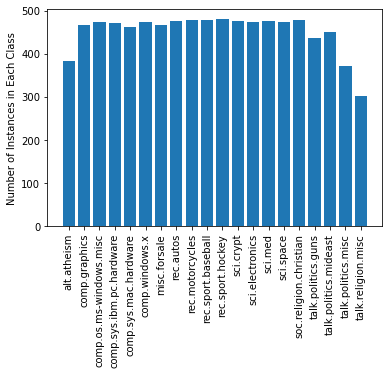

In [23]:
from sklearn.model_selection import train_test_split
# Split it into train / test subsets
X_train, X_test, y_train_ohe, y_test_ohe = train_test_split(X, y_ohe, test_size=0.2,
                                                            stratify=bunch.target, 
                                                            random_state=42)
NUM_CLASSES = 20

# print some stats of the data
print("X_train Shape:",X_train.shape, "Label Shape:", y_train_ohe.shape)
uniq_classes = np.sum(y_train_ohe,axis=0)
plt.bar(list(range(20)),uniq_classes)
plt.xticks(list(range(20)), bunch.target_names, rotation='vertical')
plt.ylabel("Number of Instances in Each Class")
plt.show()

## Loading the embedding
But this is going to be a more involved process. Maybe we can speed up the training by loading up a pre-trained embedding of the words?!

Let's use the GloVe word embedding in keras. We will follow the example at:
- https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

You can download the nearly 1GB pretrained embeddings here:
- http://nlp.stanford.edu/data/glove.6B.zip

Let's take a quick look at the format of the file:

In [26]:
!ls -a "large_data/glove/" 

.                 glove.6B.100d.txt glove.6B.300d.txt
..                glove.6B.200d.txt glove.6B.50d.txt


In [27]:
!head "large_data/glove/glove.6B.50d.txt"

the 0.418 0.24968 -0.41242 0.1217 0.34527 -0.044457 -0.49688 -0.17862 -0.00066023 -0.6566 0.27843 -0.14767 -0.55677 0.14658 -0.0095095 0.011658 0.10204 -0.12792 -0.8443 -0.12181 -0.016801 -0.33279 -0.1552 -0.23131 -0.19181 -1.8823 -0.76746 0.099051 -0.42125 -0.19526 4.0071 -0.18594 -0.52287 -0.31681 0.00059213 0.0074449 0.17778 -0.15897 0.012041 -0.054223 -0.29871 -0.15749 -0.34758 -0.045637 -0.44251 0.18785 0.0027849 -0.18411 -0.11514 -0.78581
, 0.013441 0.23682 -0.16899 0.40951 0.63812 0.47709 -0.42852 -0.55641 -0.364 -0.23938 0.13001 -0.063734 -0.39575 -0.48162 0.23291 0.090201 -0.13324 0.078639 -0.41634 -0.15428 0.10068 0.48891 0.31226 -0.1252 -0.037512 -1.5179 0.12612 -0.02442 -0.042961 -0.28351 3.5416 -0.11956 -0.014533 -0.1499 0.21864 -0.33412 -0.13872 0.31806 0.70358 0.44858 -0.080262 0.63003 0.32111 -0.46765 0.22786 0.36034 -0.37818 -0.56657 0.044691 0.30392
. 0.15164 0.30177 -0.16763 0.17684 0.31719 0.33973 -0.43478 -0.31086 -0.44999 -0.29486 0.16608 0.11963 -0.41328 -0.42353

In [32]:
%%time
EMBED_SIZE = 100
# the embed size should match the file you load glove from
embeddings_index = {}
f = open('large_data/glove/glove.6B.100d.txt')
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        found_words = found_words+1

print("Embedding Shape:",embedding_matrix.shape, "\n",
      "Total words found:",found_words, "\n",
      "Percentage:",100*found_words/embedding_matrix.shape[0])

Found 400000 word vectors.
Embedding Shape: (134143, 100) 
 Total words found: 56914 
 Percentage: 42.427856839343086
CPU times: user 6.96 s, sys: 145 ms, total: 7.11 s
Wall time: 7.1 s


In [33]:
from tensorflow.keras.layers import Embedding

# save this embedding now
embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],
                            input_length=MAX_ART_LEN,
                            trainable=False)

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

rnn = Sequential()
rnn.add(embedding_layer)
rnn.add(LSTM(100,dropout=0.2, recurrent_dropout=0.2))
rnn.add(Dense(NUM_CLASSES, activation='sigmoid'))
rnn.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
print(rnn.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 100)         13414300  
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 20)                2020      
Total params: 13,496,720
Trainable params: 82,420
Non-trainable params: 13,414,300
_________________________________________________________________
None


In [35]:
history = []
tmp = rnn.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=6, batch_size=64)
history.append( tmp )

Train on 9051 samples, validate on 2263 samples
Epoch 1/6
9051/9051 [==============================] - 363s 40ms/sample - loss: 2.8493 - accuracy: 0.1138 - val_loss: 2.6135 - val_accuracy: 0.1578
Epoch 2/6
9051/9051 [==============================] - 357s 39ms/sample - loss: 2.6393 - accuracy: 0.1505 - val_loss: 2.5079 - val_accuracy: 0.1648
Epoch 3/6
9051/9051 [==============================] - 358s 40ms/sample - loss: 2.5182 - accuracy: 0.1632 - val_loss: 2.4845 - val_accuracy: 0.1829
Epoch 4/6
9051/9051 [==============================] - 347s 38ms/sample - loss: 2.3814 - accuracy: 0.1921 - val_loss: 2.2054 - val_accuracy: 0.2205
Epoch 5/6
9051/9051 [==============================] - 363s 40ms/sample - loss: 2.2085 - accuracy: 0.2432 - val_loss: 2.0055 - val_accuracy: 0.2965
Epoch 6/6
9051/9051 [==============================] - 382s 42ms/sample - loss: 2.0587 - accuracy: 0.2943 - val_loss: 1.8944 - val_accuracy: 0.3305


In [36]:
# let's extend the training by a number of epochs
tmp = rnn.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=6, batch_size=64)
history.append( tmp )

Train on 9051 samples, validate on 2263 samples
Epoch 1/6
9051/9051 [==============================] - 380s 42ms/sample - loss: 1.9154 - accuracy: 0.3324 - val_loss: 1.7110 - val_accuracy: 0.3955
Epoch 2/6
9051/9051 [==============================] - 381s 42ms/sample - loss: 1.7238 - accuracy: 0.4002 - val_loss: 1.4770 - val_accuracy: 0.4887
Epoch 3/6
9051/9051 [==============================] - 358s 40ms/sample - loss: 1.5282 - accuracy: 0.4736 - val_loss: 1.3275 - val_accuracy: 0.5369
Epoch 4/6
9051/9051 [==============================] - 348s 38ms/sample - loss: 1.3424 - accuracy: 0.5435 - val_loss: 1.1766 - val_accuracy: 0.6186
Epoch 5/6
9051/9051 [==============================] - 345s 38ms/sample - loss: 1.2069 - accuracy: 0.5905 - val_loss: 1.0639 - val_accuracy: 0.6403
Epoch 6/6
9051/9051 [==============================] - 347s 38ms/sample - loss: 1.0899 - accuracy: 0.6358 - val_loss: 0.9566 - val_accuracy: 0.6911


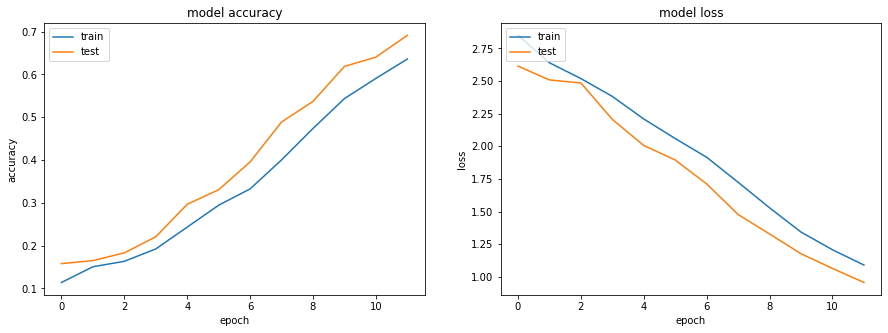

In [43]:
# combine all the history from training together
combined = dict()
for key in ['accuracy','val_accuracy','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in history])
    
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['accuracy'])
plt.plot(combined['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Are these converged? No! Not even close!!! We need to run these fo many more epochs. 

## [Back to Slides]

# From Recurrent back to Convolutional
Since all the sequences are now the same length, it is possible to construct a convolutional network on top of the embedded sequence outputs. Once embedded, there really is not too much difference in representation about the data and an image (though the data clearly has a different intuition). We will follow these steps:
- use an embedding layer to translate to a dense representation of the entire sequence
- train 1D filters to convolve with the output of the embedded sequence
 - note: 1D filters doesn't mean they are only one dimension, it means the filters are looped through in a single dimension. The size of the filter is [`kernel_size x embed_size`]. It loops through the entire embedding, over a number of words at a time.


In [46]:
# but wait, if we are just making the sequences of this all the same size
#  can't we just use a 1-D convolutional network? 

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Embedding

EMBED_SIZE = 100 
sequence_input = Input(shape=(MAX_ART_LEN,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input) # from previous embedding
x = Conv1D(128, 5, activation='relu',kernel_initializer='he_uniform')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu',kernel_initializer='he_uniform')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu',kernel_initializer='he_uniform')(x)
x = MaxPooling1D(35)(x)  
x = Flatten()(x)
x = Dense(128, activation='relu',kernel_initializer='he_uniform')(x)
preds = Dense(NUM_CLASSES, activation='softmax',kernel_initializer='glorot_uniform')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print(model.summary())
histories = []
tmp = model.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe),
          epochs=2, batch_size=128)
histories.append(tmp)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         13414300  
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 35, 128)           8204

In [47]:
tmp = model.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe),
          epochs=10, batch_size=128)
histories.append(tmp)

Train on 9051 samples, validate on 2263 samples
Epoch 1/10
9051/9051 [==============================] - 55s 6ms/sample - loss: 1.6270 - acc: 0.4527 - val_loss: 1.7161 - val_acc: 0.4132
Epoch 2/10
9051/9051 [==============================] - 56s 6ms/sample - loss: 1.2717 - acc: 0.5720 - val_loss: 1.1966 - val_acc: 0.6036
Epoch 3/10
9051/9051 [==============================] - 55s 6ms/sample - loss: 1.0289 - acc: 0.6611 - val_loss: 1.0853 - val_acc: 0.6279
Epoch 4/10
9051/9051 [==============================] - 56s 6ms/sample - loss: 0.8188 - acc: 0.7301 - val_loss: 0.9733 - val_acc: 0.6655
Epoch 5/10
9051/9051 [==============================] - 56s 6ms/sample - loss: 0.6687 - acc: 0.7815 - val_loss: 1.0663 - val_acc: 0.6456
Epoch 6/10
9051/9051 [==============================] - 56s 6ms/sample - loss: 0.5568 - acc: 0.8156 - val_loss: 1.0481 - val_acc: 0.6677
Epoch 7/10
9051/9051 [==============================] - 56s 6ms/sample - loss: 0.4445 - acc: 0.8657 - val_loss: 0.8607 - val_acc: 

In [48]:
tmp = model.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe),
          epochs=10, batch_size=128)
histories.append(tmp)

Train on 9051 samples, validate on 2263 samples
Epoch 1/10
9051/9051 [==============================] - 56s 6ms/sample - loss: 0.1936 - acc: 0.9517 - val_loss: 0.7875 - val_acc: 0.7707
Epoch 2/10
9051/9051 [==============================] - 56s 6ms/sample - loss: 0.2538 - acc: 0.9460 - val_loss: 0.7788 - val_acc: 0.7711
Epoch 3/10
9051/9051 [==============================] - 56s 6ms/sample - loss: 0.1032 - acc: 0.9774 - val_loss: 0.9063 - val_acc: 0.7534
Epoch 4/10
9051/9051 [==============================] - 55s 6ms/sample - loss: 0.1512 - acc: 0.9677 - val_loss: 2.2205 - val_acc: 0.5705
Epoch 5/10
9051/9051 [==============================] - 55s 6ms/sample - loss: 0.0985 - acc: 0.9786 - val_loss: 2.5726 - val_acc: 0.5882
Epoch 6/10
9051/9051 [==============================] - 54s 6ms/sample - loss: 0.1694 - acc: 0.9722 - val_loss: 2.0771 - val_acc: 0.6200
Epoch 7/10
9051/9051 [==============================] - 54s 6ms/sample - loss: 0.1254 - acc: 0.9770 - val_loss: 1.3630 - val_acc: 

In [49]:
tmp = model.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe),
          epochs=10, batch_size=128)
histories.append(tmp)

Train on 9051 samples, validate on 2263 samples
Epoch 1/10
9051/9051 [==============================] - 54s 6ms/sample - loss: 0.0973 - acc: 0.9829 - val_loss: 1.0485 - val_acc: 0.7698
Epoch 2/10
9051/9051 [==============================] - 54s 6ms/sample - loss: 0.0639 - acc: 0.9886 - val_loss: 1.0578 - val_acc: 0.7839
Epoch 3/10
9051/9051 [==============================] - 53s 6ms/sample - loss: 0.0913 - acc: 0.9846 - val_loss: 0.9758 - val_acc: 0.7936
Epoch 4/10
9051/9051 [==============================] - 54s 6ms/sample - loss: 0.1390 - acc: 0.9809 - val_loss: 3.1130 - val_acc: 0.6505
Epoch 5/10
9051/9051 [==============================] - 55s 6ms/sample - loss: 0.1432 - acc: 0.9778 - val_loss: 0.9603 - val_acc: 0.7897
Epoch 6/10
9051/9051 [==============================] - 55s 6ms/sample - loss: 0.1280 - acc: 0.9788 - val_loss: 0.9803 - val_acc: 0.7901
Epoch 7/10
9051/9051 [==============================] - 56s 6ms/sample - loss: 0.1652 - acc: 0.9848 - val_loss: 0.9221 - val_acc: 

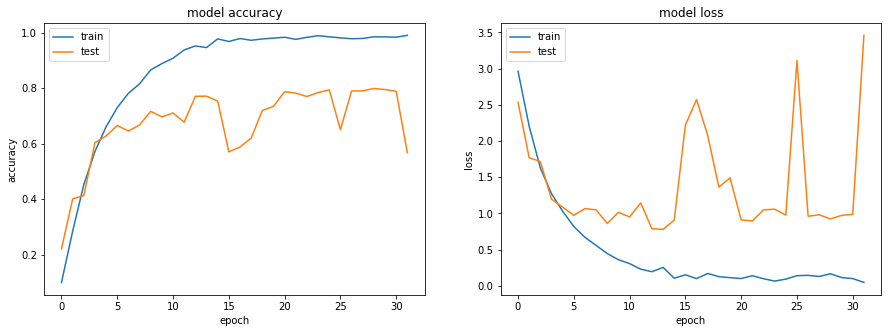

In [52]:
# combine all the history from training together
combined = dict()
for key in ['acc','val_acc','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in histories])
    
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['acc'])
plt.plot(combined['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Okay. So we seem to be maxing out the performance on the validation set. The results are pretty good--I would expect these to be about a top 10 submission on a class-based Kaggle competition. Nice!
- https://inclass.kaggle.com/c/cs5740-20-newsgroups-classification/leaderboard

**[End of Lecture Demo]**

Below is an archive of discussions from previous semesters. WHile it is interesting, it is not critical to the understanding of recurrent neural networks. 

# [ARCHIVED]
# But others have done much better on 20 News groups! 

Why are we not getting the 95% on the data? Let's take a look at the original posting by the Keras blog. They claim that they get validation accuracy of 95% after two epochs!

Why are we not getting that same accuracy?  
- https://github.com/kimardenmiller/NLP_CNN/blob/master/Embeddings/0.0.4%20word%20index%20save.py

In [70]:
# from __future__ import print_function
import os
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
import sys
import pandas as pd
import pickle
from keras.models import load_model

np.random.seed(1337)

BASE_DIR = ''
GLOVE_DIR = 'large_data/glove'
TEXT_DATA_DIR = 'large_data/20news-bydate/20news-bydate-train/'
TEXT_DATA_DIR = 'large_data/20_newsgroups/'
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

# first, build index mapping words in the embeddings set to their embedding vector
print('Indexing word vectors.')

embeddings_index = {}

f = open('large_data/glove/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

# second, prepare text samples and their labels
print('Processing text data set')

texts = []  # list of text samples
labels_index = {}  # dictionary mapping label news_group to numeric id
labels = []  # list of label ids
for news_group in sorted(os.listdir(TEXT_DATA_DIR)):
    path = os.path.join(TEXT_DATA_DIR, news_group)
    if os.path.isdir(path):
        label_id = len(labels_index)
        labels_index[news_group] = label_id
        for post in sorted(os.listdir(path)):
            if post.isdigit():
                post_path = os.path.join(path, post)
                if sys.version_info < (3,):
                    f = open(post_path)
                else:
                    f = open(post_path, encoding='latin-1')
                texts.append(f.read())
                f.close()
                labels.append(label_id)

print('Found %s texts.' % len(texts))
print(texts[0])

# override with sklearn
# texts = bunch.data
# labels = bunch.target
# labels_index = bunch.target_names

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
pickle.dump(tokenizer, open('large_data/tokenizer.004.p', 'wb'))
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
# print('Word index', word_index.values())

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Sample data tensor:', data[0, 0:])
print('Shape of label tensor:', labels.shape)
print('Sample label tensor:', labels[690:750, 0:])
# sys.exit()

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

print('Preparing embedding matrix.')

# prepare embedding matrix
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NB_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(nb_words + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

print('Training model.')

# train a 1D convnet with global maxpooling
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(35)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(len(labels_index), activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

model.fit(x_train, y_train, validation_data=(x_val, y_val),
          nb_epoch=2, batch_size=128)

#  Dec 30, 2016  loss: 0.3069 - acc: 0.8908 - val_loss: 0.1421 - val_acc: 0.9549

# # First evaluation of the model
# scores = model.evaluate(x_val, y_val, verbose=0)
# print("Accuracy of Run Model: %.2f%%" % (scores[1]*100))

# model.save('../saved_models/0.0.4_model.h5')
# np.save('../saved_models/0.0.4_word_index.npy', word_index)

# del model  # deletes the existing model

# # returns a compiled model identical to the previous one
# model = load_model('../saved_models/0.0.4_model.h5')

# # Final evaluation of the model
# scores = model.evaluate(x_val, y_val, verbose=0)
# print("Accuracy of Disk-Loaded Model: %.2f%%" % (scores[1]*100))

Indexing word vectors.
Processing text data set
Found 19997 texts.
Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:49960 alt.atheism.moderated:713 news.answers:7054 alt.answers:126
Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!bb3.andrew.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!magnus.acs.ohio-state.edu!usenet.ins.cwru.edu!agate!spool.mu.edu!uunet!pipex!ibmpcug!mantis!mathew
From: mathew <mathew@mantis.co.uk>
Newsgroups: alt.atheism,alt.atheism.moderated,news.answers,alt.answers
Subject: Alt.Atheism FAQ: Atheist Resources
Summary: Books, addresses, music -- anything related to atheism
Keywords: FAQ, atheism, books, music, fiction, addresses, contacts
Message-ID: <19930329115719@mantis.co.uk>
Date: Mon, 29 Mar 1993 11:57:19 GMT
Expires: Thu, 29 Apr 1993 11:57:19 GMT
Followup-To: alt.atheism
Distribution: world
Organization: Mantis Consultants, Cambridge. UK.
Approved: news-answers-request@mit.edu
Supersedes: <19930301143317@mantis.co.uk>
Lines: 290

Archive-name: atheism/resou

/Users/eclarson/anaconda/envs/MLEnv/lib/python3.5/site-packages/keras/preprocessing/text.py:89: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 214873 unique tokens.
Shape of data tensor: (19997, 1000)
Sample data tensor: [  447   119   489   755    76   696  2362    10    76   118  3007    83
   814     4   216    76  7208 16127  7084   126     1   516    25     4
    83  9295 12513  7994     5  3773  7097     5   393     4   719     6
   933     3     5  1891  2154     3  2977     5  7449    18 13741     1
    97     1  7097  4952     3  2842   807    18     1  7994  1249     9
  3477     3 15061     5 10707     6  7469  9926     5     4   760    14
   234  2234     4     5   489   480   188     1 11088  8086    14     1
  4304 11974     4  1131   226  1483     9  3096   186   126  2129    47
     5  6103  2438  5693     4  3144    35  1768  3639  3058    76     9
 13222    47   126 18603     6  2056  1226     6 15022   108  3903  3798
     1  3639  5090   216   719    47   742     5  1044  2066  8364    28
   423  5236    18   325  2062   159  1509   423     9  5744     6   314
    23 11655    47     5   859   451  14

/Users/eclarson/anaconda/envs/MLEnv/lib/python3.5/site-packages/ipykernel/__main__.py:148: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 15998 samples, validate on 3999 samples
Epoch 1/2
15998/15998 [==============================] - 281s - loss: 1.9110 - acc: 0.3264 - val_loss: 0.9826 - val_acc: 0.638
Epoch 2/2
15998/15998 [==============================] - 293s - loss: 0.7430 - acc: 0.7523 - val_loss: 1.3303 - val_acc: 0.56


In [71]:
model.fit(x_train, y_train, validation_data=(x_val, y_val),
          nb_epoch=2, batch_size=128)

/Users/eclarson/anaconda/envs/MLEnv/lib/python3.5/site-packages/ipykernel/__main__.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  from ipykernel import kernelapp as app


Train on 15998 samples, validate on 3999 samples
Epoch 1/2
15998/15998 [==============================] - 255s - loss: 0.3346 - acc: 0.9032 - val_loss: 0.2218 - val_acc: 0.93
Epoch 2/2
15998/15998 [==============================] - 244s - loss: 0.2170 - acc: 0.9320 - val_loss: 0.2049 - val_acc: 0.94
